In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score, precision_recall_curve,precision_score,recall_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns

In [3]:
test_provider_data=pd.read_csv('Validation_Provider_9.csv')
test_wh_frauddata=test_provider_data.drop(['PotentialFraud'], axis=1)
test_provider_data.head(2)

,Provider,PotentialFraud
0,PRV51005,Yes
1,PRV51008,No


In [4]:
test_benf_data= pd.read_csv('Validation_Beneficiary_9.csv')
test_benf_data.head(2)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,1,2,2,2,2,0,0,1790,1200
1,BENE11011,1914-03-01,NaN,2,2,0,1,360,12,12,...,1,1,2,2,1,1,5000,1068,250,320


In [5]:
test_inpatient = pd.read_csv('Validation_Inpatient_9.csv')
test_inpatient.head(2)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN
1,BENE11034,CLM31519,2008-12-29,2009-01-05,PRV55215,29000,PHY355604,PHY415867,NaN,2008-12-29,...,4019,4111,4589,NaN,3612.0,4139.0,NaN,NaN,NaN,NaN


In [6]:
test_outpatient=pd.read_csv('Validation_Outpatient_9.csv')
test_outpatient.head(2)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11005,CLM605760,2009-09-30,2009-10-20,PRV54064,50,PHY419180,NaN,PHY419180,71944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200,NaN
1,BENE11011,CLM347780,2009-05-08,2009-05-08,PRV51012,50,PHY429635,NaN,PHY322331,37500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,37611


In [7]:
test_provider_data.shape

(1082, 2)

In [8]:
test_benf_data.shape

(61836, 25)

In [9]:
def Newfeature_groupby(Test_data, op_col2,op, group_col):
    '''
    This function creates a new feature using groupby operation. it groups the test and train data using col1 
    and apply the aggregate functions on top of col2
    '''
    for g_col in group_col:
        Test=pd.DataFrame()
        for col in op_col2:
            # new column name for the dataframe
            new_name = 'Per'+''.join(g_col)+'_'+col+'_'+op
            Test[new_name] = Test_data.groupby(g_col)[col].transform(op)
            
        Test_data=pd.concat([Test,Test_data], axis=1)
    return Test_data

In [10]:
def predict_cluster(Test_data):
   
    X=Test_data.drop(['Provider'],axis=1)
    if 'PotentialFraud' in X.columns:
        X=Test_data.drop(['PotentialFraud', 'Provider'],axis=1)
    with open('std_scaler.pkl', 'rb') as f:
        std_scaler = pickle.load(f)
    std_data=std_scaler.transform(X)
    with open('PCA.pkl', 'rb') as f:
        PCA = pickle.load(f)
    pca_data=PCA.transform(std_data)
    
    with open('kmeans25.pkl', 'rb') as f:
        Kmeans = pickle.load(f)
        
    y_pred=Kmeans.predict(pca_data)
    
    return y_pred

In [11]:
def preprocess_data(test_provider_data,test_benf_data, test_inpatient, test_outpatient):
    test_benf_data[['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure','ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
                   'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression','ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
                   'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis','ChronicCond_stroke']] = test_benf_data[
                   ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure','ChronicCond_KidneyDisease', 'ChronicCond_Cancer','ChronicCond_ObstrPulmonary',
                   'ChronicCond_Depression','ChronicCond_Diabetes', 'ChronicCond_IschemicHeart','ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                   'ChronicCond_stroke']].replace(to_replace=2,value=0)
    
    test_benf_data['risk_score']=test_benf_data['ChronicCond_Alzheimer']+test_benf_data['ChronicCond_Cancer']+test_benf_data['ChronicCond_Depression']\
                              +test_benf_data['ChronicCond_Diabetes']+test_benf_data['ChronicCond_Heartfailure']+test_benf_data['ChronicCond_IschemicHeart']\
                              +test_benf_data['ChronicCond_KidneyDisease']+test_benf_data['ChronicCond_KidneyDisease']+test_benf_data['ChronicCond_Osteoporasis']\
                              +test_benf_data['ChronicCond_Osteoporasis']+test_benf_data['ChronicCond_rheumatoidarthritis']
    
    test_benf_data['DOB'] = pd.to_datetime(test_benf_data['DOB'] , format = '%Y-%m-%d')
    test_benf_data['DOD'] = pd.to_datetime(test_benf_data['DOD'],format = '%Y-%m-%d',errors='ignore')

    test_benf_data['age']= round(((test_benf_data['DOD'] -test_benf_data['DOB']).dt.days)/365)
    test_benf_data['age']=test_benf_data['age'].fillna(round(((pd.to_datetime('2009-12-01' , format = '%Y-%m-%d') - test_benf_data['DOB']).dt.days)/365))
    
    test_benf_data['died'] = 0
    test_benf_data.loc[test_benf_data.DOD.notna(), 'died'] = 1
    test_benf_data.loc[test_benf_data.age > 90, 'died'] = 1
    
    test_inpatient['ClaimStartDt'] = pd.to_datetime(test_inpatient['ClaimStartDt'] , format = '%Y-%m-%d')
    test_inpatient['ClaimEndDt'] = pd.to_datetime(test_inpatient['ClaimEndDt'],format = '%Y-%m-%d')
    test_inpatient['claim_period'] = ((test_inpatient['ClaimEndDt'] - test_inpatient['ClaimStartDt']).dt.days)+1

    test_inpatient['AdmissionDt'] = pd.to_datetime(test_inpatient['AdmissionDt'] , format = '%Y-%m-%d')
    test_inpatient['DischargeDt'] = pd.to_datetime(test_inpatient['DischargeDt'],format = '%Y-%m-%d')
    test_inpatient['Hospitalized_period'] = ((test_inpatient['DischargeDt'] - test_inpatient['AdmissionDt']).dt.days)+1

    test_inpatient['ExtraClaimDays'] = np.where( test_inpatient['claim_period']>test_inpatient['Hospitalized_period'], test_inpatient['claim_period'] - test_inpatient['Hospitalized_period'], 0)
    test_inpatient['same_physician'] = np.where( test_inpatient['AttendingPhysician']==test_inpatient['OperatingPhysician'], 1, 0)

    test_outpatient['ClaimStartDt'] = pd.to_datetime(test_outpatient['ClaimStartDt'] , format = '%Y-%m-%d')
    test_outpatient['ClaimEndDt'] = pd.to_datetime(test_outpatient['ClaimEndDt'],format = '%Y-%m-%d')
    test_outpatient['claim_period'] = ((test_outpatient['ClaimEndDt'] - test_outpatient['ClaimStartDt']).dt.days)+1

    test_outpatient['same_physician'] = np.where( test_outpatient['AttendingPhysician']==test_outpatient['OperatingPhysician'], 1, 0)

    test_inpatient['In_Outpatient'] = 1
    test_outpatient['In_Outpatient'] = 0
    
    # Merge inpatient and outpatient dataframes based on common columns
    common_columns_test = [ idx for idx in test_outpatient.columns if idx in test_inpatient.columns]
    Inpatient_Outpatient_Merge_Te = pd.merge(test_inpatient, test_outpatient, left_on = common_columns_test, right_on = common_columns_test,how = 'outer')

    # Merge beneficiary details with inpatient and outpatient data
    Inpatient_Outpatient_Beneficiary_Merge_Te = pd.merge(Inpatient_Outpatient_Merge_Te, test_benf_data,left_on='BeneID',right_on='BeneID',how='inner')

    Final_Test_data = pd.merge(Inpatient_Outpatient_Beneficiary_Merge_Te, test_provider_data , how = 'inner', on = 'Provider' )
    Final_Test_data = Final_Test_data.fillna(0)
    

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'age', 'Hospitalized_period', 'claim_period', 'risk_score']
    new_groupby_columns=['BeneID','AttendingPhysician','OperatingPhysician','OtherPhysician',
                    'ClmAdmitDiagnosisCode','DiagnosisGroupCode',
                    'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
                    'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
                    'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
                    'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
                    'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
                    'ClmProcedureCode_6']

    Final_Test_data =  Newfeature_groupby(Final_Test_data, columns, 'median', new_groupby_columns)

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'age', 'Hospitalized_period', 'claim_period', 'risk_score']
    new_groupby_columns=['Provider']
    Final_Test_data =  Newfeature_groupby( Final_Test_data,columns, 'count', new_groupby_columns)

    # Convert type of Gender and Race to categorical
    Final_Test_data.Gender=Final_Test_data.Gender.astype('category')

    Final_Test_data.Race=Final_Test_data.Race.astype('category')

    #https://datagy.io/pandas-get-dummies/
    # Do one hot encoding for gender and Race
    Final_Test_data=pd.get_dummies(Final_Test_data,columns=['Gender','Race'])

    Final_Test_data['RenalDiseaseIndicator']=Final_Test_data.RenalDiseaseIndicator.replace(['Y'],1)
    if 'PotentialFraud' in Final_Test_data.columns:
        Final_Test_data['PotentialFraud']=Final_Test_data.PotentialFraud.replace(['Yes','No'],[1,0])

    remove_columns=['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician','OperatingPhysician', 'OtherPhysician',
                'ClmDiagnosisCode_1','ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4','ClmDiagnosisCode_5',
                'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7','ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
                'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3','ClmProcedureCode_4', 'ClmProcedureCode_5',
                'ClmProcedureCode_6','ClmAdmitDiagnosisCode', 'AdmissionDt','DischargeDt', 'DiagnosisGroupCode','DOB', 'DOD','State', 'County']

    Final_Test_data=Final_Test_data.drop(columns=remove_columns, axis=1)
    
    Final_Test_data['cluster']=predict_cluster(Final_Test_data)
    return Final_Test_data

In [12]:
Test=preprocess_data(test_provider_data,test_benf_data, test_inpatient, test_outpatient)
Test.head()

,PerProvider_InscClaimAmtReimbursed_count,PerProvider_DeductibleAmtPaid_count,PerProvider_IPAnnualReimbursementAmt_count,PerProvider_IPAnnualDeductibleAmt_count,PerProvider_OPAnnualReimbursementAmt_count,PerProvider_OPAnnualDeductibleAmt_count,PerProvider_age_count,PerProvider_Hospitalized_period_count,PerProvider_claim_period_count,PerProvider_risk_score_count,...,age,died,PotentialFraud,Gender_1,Gender_2,Race_1,Race_2,Race_3,Race_5,cluster
0,26,26,26,26,26,26,26,26,26,26,...,72.0,0,0,0,1,1,0,0,0,14
1,26,26,26,26,26,26,26,26,26,26,...,83.0,0,0,0,1,1,0,0,0,19
2,26,26,26,26,26,26,26,26,26,26,...,72.0,0,0,1,0,0,0,1,0,0
3,26,26,26,26,26,26,26,26,26,26,...,89.0,0,0,0,1,1,0,0,0,14
4,26,26,26,26,26,26,26,26,26,26,...,89.0,0,0,0,1,1,0,0,0,6


In [13]:
# create a dictionary which will contain all the files
X = {"Test_Provider":test_wh_frauddata, "Test_Beneficiary":test_benf_data, "Test_Inpatient":test_inpatient, "Test_Outpatient":test_outpatient}

In [14]:
def final_fun_1(X):
    # Load the raw train data
    Test_Provider = X['Test_Provider']
    Test_Beneficiary = X['Test_Beneficiary']
    Test_Inpatient = X['Test_Inpatient']
    Test_Outpatient = X['Test_Outpatient']
    
    Final_data= preprocess_data(Test_Provider,Test_Beneficiary,Test_Inpatient,Test_Outpatient)
#     print(Final_data.shape)
#     print(Final_data.columns)
#     if 'PotentialFraud' in Final_data.columns:
#         print('yes')
    # drop provider column
    test_provider = Final_data[['Provider']]
    test_data = Final_data.drop(axis=1,columns=['Provider'])

    # Standardize the data
    with open('std_scaler1.pkl', 'rb') as f:
        std_scaler = pickle.load(f)
    std_scaler.transform(test_data)
    
    with open('log_reg.pkl', 'rb') as f:
        best_model = pickle.load(f)
        
    y_pred=best_model.predict(test_data)
    test_provider['PredictedFraud']=y_pred
    
    return test_provider

In [15]:
test_provider_predicted= final_fun_1(X)
test_provider_predicted.head(10)

C:\Users\HP\anaconda3\envs\tf-gpu1\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\HP\AppData\Local\Temp\ipykernel_20760\2489347790.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_provider['PredictedFraud']=y_pred


,Provider,PredictedFraud
0,PRV56614,1
1,PRV56614,1
2,PRV56614,0
3,PRV56614,1
4,PRV56614,1
5,PRV56614,1
6,PRV56614,1
7,PRV56614,1
8,PRV56614,1
9,PRV56614,1


In [16]:
def pred_prob(clf, data): 
    # predicts the probabability of class label using the model
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [17]:
def draw_test_roc(test_fpr, test_tpr):
    # calculate auc for test
    plt.figure(figsize=(10,6))
    test_auc = auc(test_fpr, test_tpr)
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)", size = 14)
    plt.ylabel("True Positive Rate(TPR)", size = 14)
    plt.title("Area Under Curve", size = 16)
    plt.grid(b=True, which='major', color='g', linestyle='-')
    plt.show()

In [18]:
from sklearn.metrics import confusion_matrix
def draw_test_confusion_matrix(best_t, x_test, y_test, y_test_pred):
    plt.figure(figsize=(10,6))
    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    sns.heatmap(cm, annot=True, fmt='d') #, ax=ax[1]
    plt.title('Test Dataset Confusion Matrix', size = 16)
    plt.xlabel("Predicted Label", size = 14)
    plt.ylabel("Actual Label", size = 14)
    plt.show()
    print("Number of misclassified points ",(len(y_test_pred)-np.trace(cm))/len(y_test_pred)*100)
    return test_prediction

In [19]:
def validate_test_model(clf, x_test, y_test, best_t):
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    # calculate tpr, fpr for diffeent thresholds using roc_curve
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    test_auc = auc(test_fpr, test_tpr)
    print("Test AUC = ", test_auc)
    
    draw_test_roc(test_fpr, test_tpr)
    #def draw_test_confusion_matrix(best_t, x_test, y_test, y_test_pred):
    test_prediction = draw_test_confusion_matrix(best_t, x_test, y_test, y_test_pred)
    test_f1_score = f1_score(y_test, test_prediction)
    return test_auc

In [20]:
# create a dictionary which will contain all the files
X = {"Test_Provider":test_provider_data, "Test_Beneficiary":test_benf_data, "Test_Inpatient":test_inpatient, "Test_Outpatient":test_outpatient}

In [30]:
from datetime import datetime
def final_fun_2(X):
    start = datetime.now()
    # Load the raw train data
    Test_Provider = X['Test_Provider']
    Test_Beneficiary = X['Test_Beneficiary']
    Test_Inpatient = X['Test_Inpatient']
    Test_Outpatient = X['Test_Outpatient']
    
    Final_data= preprocess_data(Test_Provider,Test_Beneficiary,Test_Inpatient,Test_Outpatient)
    x_test = Final_data.drop(columns=['Provider','PotentialFraud'],axis=1)
    y_test = Final_data['PotentialFraud']

    # drop provider column
    test_provider = Final_data[['Provider']]
    test_provider['potentialFraud'] = Final_data['PotentialFraud']
    
    # Standardize the data
    standard_scaler = StandardScaler()
    standard_scaler.fit(x_test)
    test_data = standard_scaler.transform(x_test)
    
    with open('log_reg.pkl', 'rb') as f:
        best_model = pickle.load(f)
        
    y_pred=best_model.predict(test_data)
    test_provider['PredictedFraud']=y_pred
    
    # Validate RF model
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred)
    test_auc = auc(test_fpr, test_tpr)
    draw_test_roc(test_fpr, test_tpr)
    test_prediction = draw_test_confusion_matrix(0.2678, x_test, y_test, y_pred)
    test_f1_score = f1_score(y_test, test_prediction)
    precision=precision_score(y_test, test_prediction)
    recall=recall_score(y_test, test_prediction)
    end= datetime.now()
    print('Time taken to predict test data', end-start)
    print("Test AUC = ", test_auc)
    print("F1 Score = ", test_f1_score)
    print("Precision = ", precision)
    print("Recall = ", recall)
    
    return test_provider, test_auc,test_f1_score

C:\Users\HP\AppData\Local\Temp\ipykernel_20760\3265344727.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_provider['potentialFraud'] = Final_data['PotentialFraud']
C:\Users\HP\AppData\Local\Temp\ipykernel_20760\3265344727.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_provider['PredictedFraud']=y_pred
C:\Users\HP\AppData\Local\Temp\ipykernel_20760\465495426.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the o

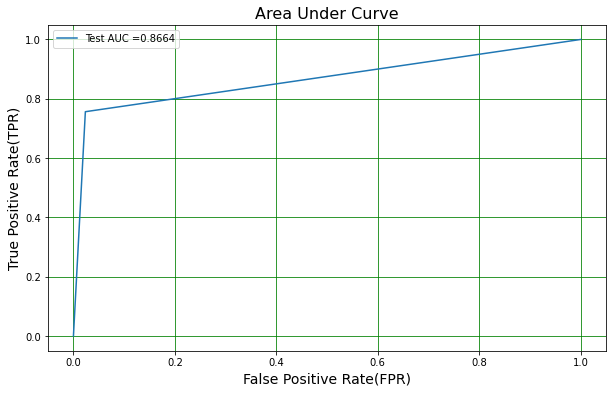

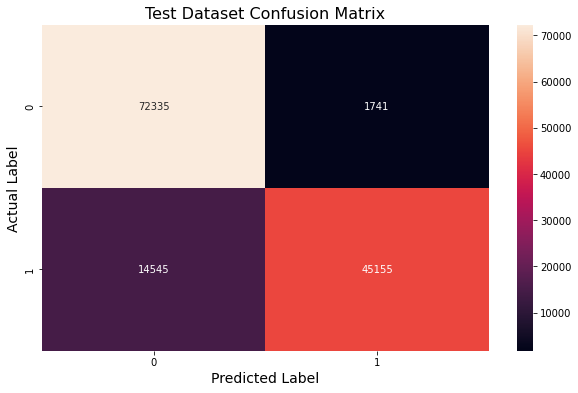

Number of misclassified points  12.174082047601962
Time taken to predict test data 0:00:15.647910
Test AUC =  0.8664311351020451
F1 Score =  0.8472175316146946
Precision =  0.9628752985329239
Recall =  0.7563651591289782


In [31]:
# call final_fun_2 for prediction
x_test_provider, test_auc, test_f1_score = final_fun_2(X)

In [32]:
x_test_provider.head(50)

,Provider,potentialFraud,PredictedFraud
0,PRV56614,0,0
1,PRV56614,0,0
2,PRV56614,0,0
3,PRV56614,0,0
4,PRV56614,0,0
5,PRV56614,0,0
6,PRV56614,0,0
7,PRV56614,0,0
8,PRV56614,0,0
9,PRV56614,0,0


In [33]:
x_test_provider.tail(50)

,Provider,potentialFraud,PredictedFraud
133726,PRV57564,0,0
133727,PRV57564,0,0
133728,PRV54006,0,0
133729,PRV55078,0,0
133730,PRV55617,0,0
133731,PRV55617,0,0
133732,PRV55329,0,0
133733,PRV55329,0,0
133734,PRV55302,0,0
133735,PRV55364,0,0


### Conclusion

1. we used logistic regression for modelling with hyperparameter c-0.001
2. we considered F1 score as the primary metric for evaluating the model. As we already discussed in EDA part.
3. we even checked the individual precision and recall while modelling. 
4. our best model results are
<br>
   Time taken to predict test data is 15.647910 sec.
   <br>Test AUC is 0.866
   <br>F1 Score is 0.847
   <br>Precision is 0.96
   <br>Recall is 0.756
   <br>we have got good precision and f1 score.<br>
</br>

5. we have also displayed the predicted and truth values for 100 datapoints. our model os almost 88% accurate and predicted correctly.
6. we have only 12% misclassified points.